# Deploy and Evaluate DeepSeek-R1 Distilled Models for Performance 🚀

This notebook provides examples of inference performance of DeepSeek-R1 distilled variants on Amazon SageMaker AI. Evaluating LLM performance across key metrics—end-to-end latency, throughput, and resource efficiency—is crucial for ensuring responsiveness, scalability, and cost-effectiveness in real-world applications. Optimizing these metrics directly enhances user experience, system reliability, and deployment feasibility at scale. All DeepSeek-R1 Qwen (1.5B, 7B, 14B, 32B) and Llama (8B, 70B) variants are evaluated against four key performance metrics: 


* End-to-End Latency
* Throughput (Tokens per Second)
* Time to First Token
* Inter-Token Latency


Please note that the main purpose of this performance evaluation is to give you an indication about relative performance of distilled R1 models on different hardware. We didn’t try to optimize the performance for each model/hardware/use case combination. These results should not be treated like a best possible performance of a particular model on a particular instance type. You should always perform your own testing using your own datasets and input/output sequence length.

[LLMPerf](https://github.com/ray-project/llmperf) is not supported in py311 version!

If you're interested in installing a new pyXX kernel and register the kernel with JupyterLab notebook, follow instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-updated-jl-user-guide-customize-package-manager.html)

In [ ]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor != 11:
    pass
else:
    print(f"Python: {sys.version_info} is not supported by LLMPerf project, please change to Python3.10 or Python3.9 kernel version to continue!")

⚠️ **Please Note**: The opensource LLMPerf project does not support Text Generation Inference container - the OSS project is forked to support TGI inference. Please refer to the fork [here](https://github.com/pranavvm26/llmperf.git)

In [ ]:
!git clone https://github.com/pranavvm26/llmperf.git

In [ ]:
%pip install -e ./llmperf/

In [ ]:
%pip install -Uq sagemaker

## Step 1: Deploy DeepSeek-R1 Distilled Model Variants on Amazon SageMaker

In this step we're going to deploy DeepSeek-R1 Distilled variant models on Amazon SageMaker - below table captures the dense model size and the corresponing appropriate instance to deploy on Amazon SageMaker Endpoints for inference. The cells marked **YES** implies rightsized instance, **N/A** implies (to the left of orange cells) the instance is too small or overkill (to the right of orange cells). 

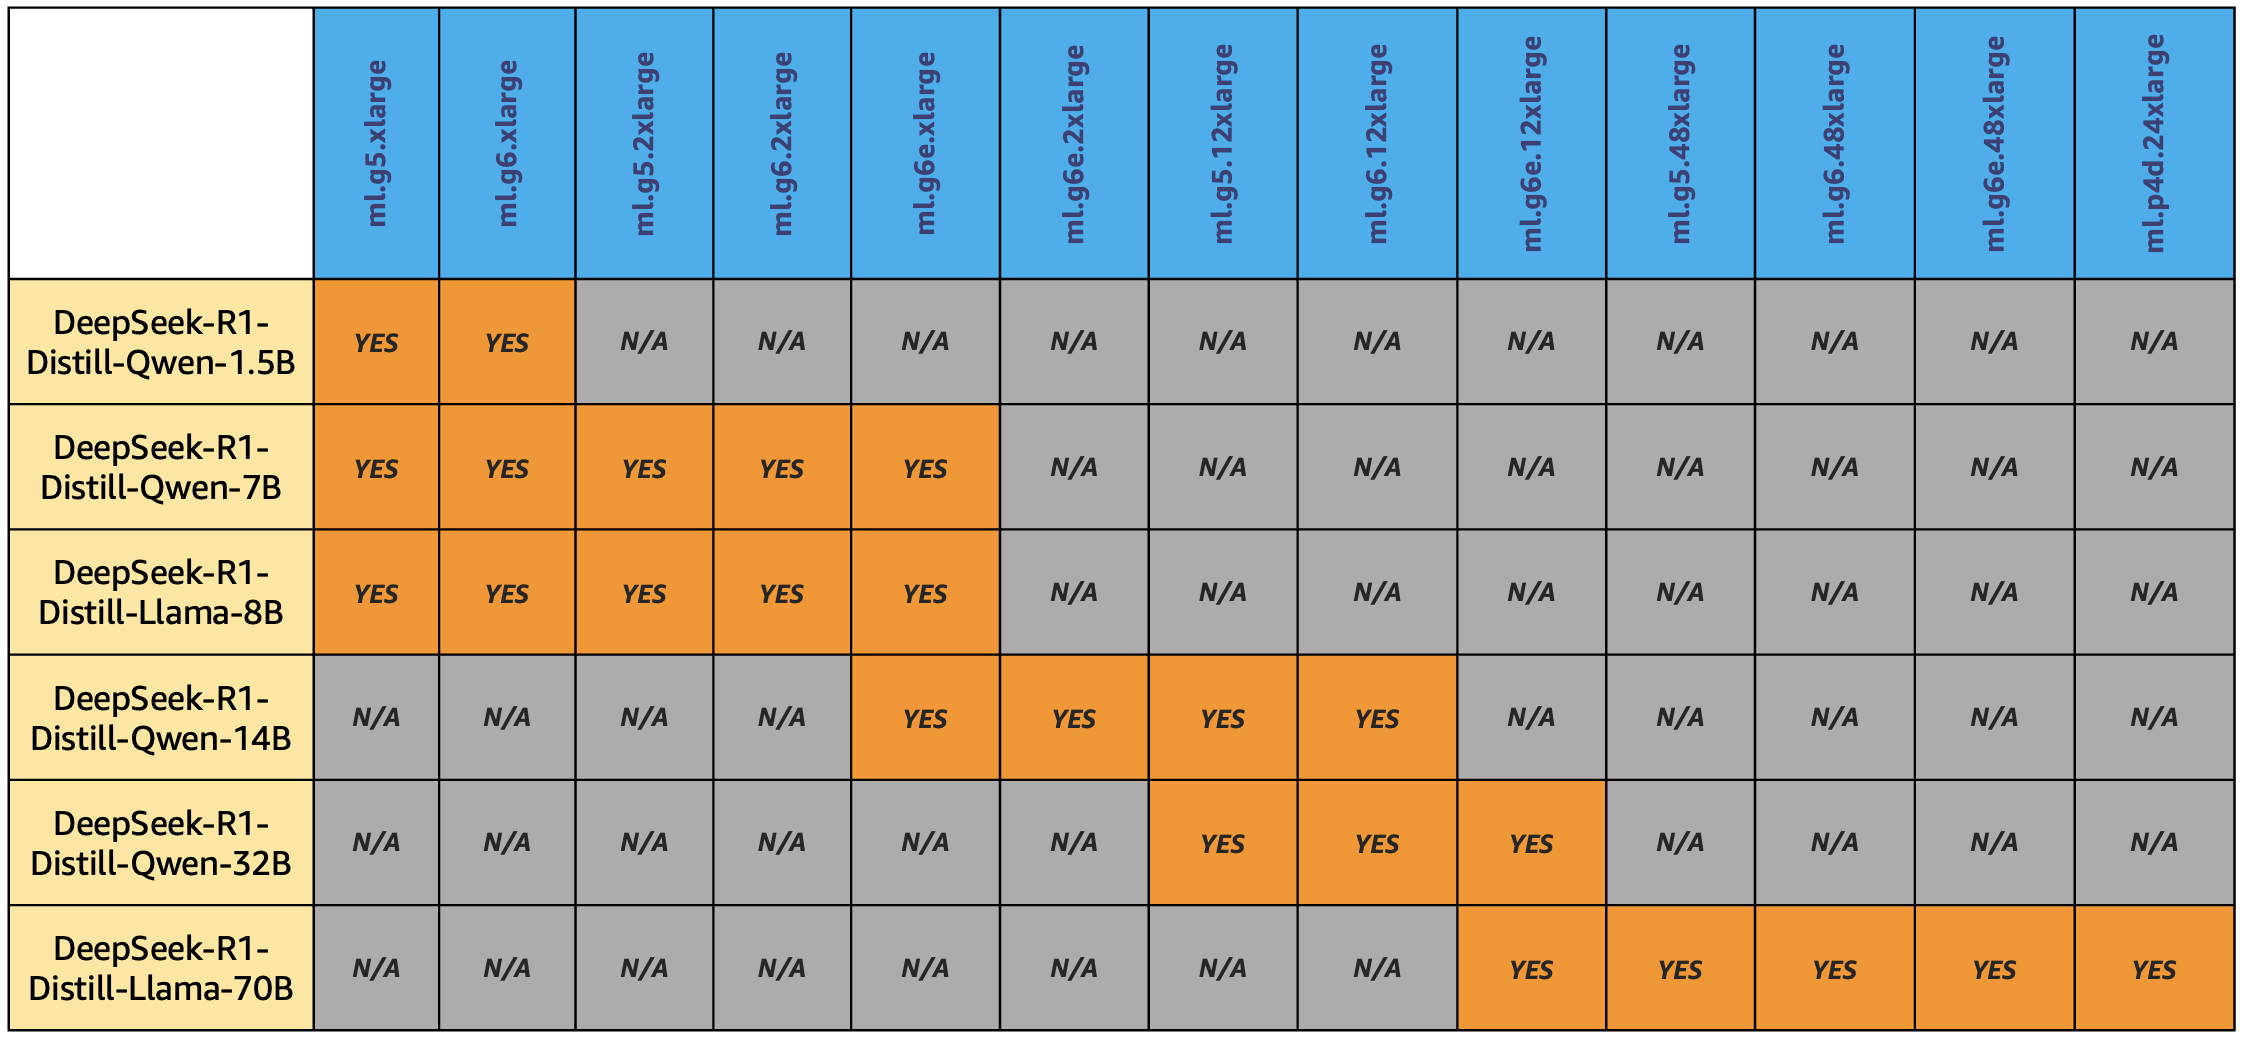

The below code comments out the deployment of all models on all possible instance types - this is done to prevent accidental deployment of a fleet of model endpoints. Please uncomment the rows below to deploy all models based on matrix configuration above.

In [ ]:
model_to_instance_mappings = {
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B": [
        ("ml.g5.xlarge", 1),
        # ("ml.g6.xlarge", 1),
    ],
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": [
    #     ("ml.g5.xlarge", 1),
    #     ("ml.g5.2xlarge", 1),
    #     ("ml.g6.xlarge", 1),
    #     ("ml.g6e.xlarge", 1),
    # ],
    # "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": [
    #     ("ml.g5.xlarge", 1),
    #     ("ml.g5.2xlarge", 1),
    #     ("ml.g6.xlarge", 1),
    #     ("ml.g6.2xlarge", 1),
    #     ("ml.g6e.xlarge", 1),
    # ],
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B": [
    #     ("ml.g5.12xlarge", 4),
    #     ("ml.g6.12xlarge", 4),
    #     ("ml.g6e.xlarge", 1),
    #     ("ml.g6.2xlarge", 1),
    #     ("ml.g6e.2xlarge", 1),
    # ],
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B": [
    #     ("ml.g5.12xlarge", 4),
    #     ("ml.g6.12xlarge", 4),
    #     ("ml.g6e.12xlarge", 4),
    # ],
    # "deepseek-ai/DeepSeek-R1-Distill-Llama-70B": [
    #     ("ml.g5.48xlarge", 8),
    #     ("ml.g6.48xlarge", 8),
    #     ("ml.g6e.12xlarge", 4),
    #     ("ml.p4d.24xlarge", 8),
    #     ("ml.g6e.48xlarge", 8),
    # ]
}

In [ ]:
import json
import sagemaker
import boto3
from typing import List, Dict
from datetime import datetime
from sagemaker.huggingface import (
    HuggingFaceModel, 
    get_huggingface_llm_image_uri
)
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

Change the version below to ensure you pick the latest supported image version from HuggingFace

In [ ]:
image_uri = get_huggingface_llm_image_uri(
     "huggingface", 
     version="3.0.1"
)
print(f"All SageMaker endpoints will be deployed on image: {image_uri}")

In [ ]:
for model_id in model_to_instance_mappings:
    
    for instance_type, num_gpus in model_to_instance_mappings[model_id]:
        
        # configure `MAX_*` below if you're interested in testing the models 
        # with longer context lengths
        runtime_env_params = {
            "HF_MODEL_ID": model_id,
            "ENDPOINT_SERVER_TIMEOUT": "3600",
            "MESSAGES_API_ENABLED": "true",
            "OPTION_ENTRYPOINT": "inference.py",
            "SAGEMAKER_ENV": "1",
            "SAGEMAKER_MODEL_SERVER_WORKERS": "1",
            "SAGEMAKER_PROGRAM": "inference.py",
            "SM_NUM_GPUS": json.dumps(num_gpus),
            "MAX_TOTAL_TOKENS": "4096",
            "MAX_INPUT_TOKENS": "3072",
            "MAX_BATCH_PREFILL_TOKENS": "3200",
            "DTYPE": "bfloat16",
            "PORT": "8080"
        }
        endpoint_name = f"{model_id.split('/')[1].replace('.', '-')}-{instance_type.replace('.', '-')}"
        model_name = f"model-for-{endpoint_name}"
        print(f"deploying {model_id} with {endpoint_name}")
        deepseek_tgi_model = HuggingFaceModel(
            image_uri=image_uri,
            env=runtime_env_params,
            role=sagemaker.get_execution_role(),
            name=model_name,
            sagemaker_session=sagemaker.Session()
        )
        pretrained_tgi_predictor = deepseek_tgi_model.deploy(
            endpoint_name=endpoint_name,
            initial_instance_count=1,
            instance_type=instance_type,
            container_startup_health_check_timeout=600,
            wait=False
        )

## Step 2: Test Model Inference with SageMaker pySDK

It's easy to invoke the endpoint with the simplified `sagemaker.Predictor` class.

In [ ]:
pt_tgi_predictor = sagemaker.Predictor(
    endpoint_name="DeepSeek-R1-Distill-Qwen-1-5B-ml-g5-xlarge",
    sagemaker_session=sagemaker.Session(),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that thinks and reasons before answering."},
    {"role": "user", "content": "How many R are in STRAWBERRY? Keep your answer and explanation short!"}
]

response_dsr1d = pt_tgi_predictor.predict(
    {
        "messages": messages,
        "max_tokens": 512,
        "temperature": 0.6
    }
)

In [ ]:
print(f"Model Response:\n{response_dsr1d['choices'][0]['message']['content']}")

## Step 3: Run Performance Evaluation using LLMPerf

We're going to run performance evaluation with some configurable metrics

In [ ]:
# list all endpoints you've deployed for testing in the list below
endpoints_deployed = ['DeepSeek-R1-Distill-Qwen-1-5B-ml-g5-xlarge']
# max input token test sizes
token_steps = [512, 3072]
# Test endpoint for concurrent innvocations
concurrency = [1]
# num of iterations of endpoint to test
max_num_requests = 10
# mean/std num of output tokens
mean_output_tokens = 256
std_output_tokens = 32

The below is a custom script to batch evaluate endpoint using llmperf against SageMaker endpoints

In [ ]:
aws_access_key_id = ""
aws_secret_access_key = ""
aws_session_token = ""
aws_region_name = ""

In [ ]:
# Convert lists to space-separated format for Bash
models_str = " ".join(f"'{model}'" for model in endpoints_deployed)
token_steps_str = " ".join(map(str, token_steps))
concurrency_str = " ".join(map(str, concurrency))

# Write to the Bash script
script_content = f"""
#!/bin/bash

export AWS_ACCESS_KEY_ID={aws_access_key_id}
export AWS_SECRET_ACCESS_KEY={aws_secret_access_key}
# export AWS_SESSION_TOKEN={aws_session_token}
export AWS_REGION_NAME={aws_region_name}

# List of model names in space-separated format
MODELS=({models_str})

# Max input token test sizes
TOKEN_STEPS=({token_steps_str})

# Test endpoint for concurrent invocations
CONCURRENCY_STEPS=({concurrency_str})

for CON in "${{CONCURRENCY_STEPS[@]}}"; do
    for TOKEN in "${{TOKEN_STEPS[@]}}"; do
        for MODEL_NAME in "${{MODELS[@]}}"; do
            RESULTS_DIR="output-results/results-concurrent-$CON-total-100/$MODEL_NAME--tok-$TOKEN--con-$CON"
        
            echo "Running ============> $MODEL_NAME || $TOKEN"
            # Create the results directory if it doesn't exist
            mkdir -p "$RESULTS_DIR"
            
            # Run the Python script with the provided model name
            python token_benchmark_ray.py \\
                --model "$MODEL_NAME" \\
                --mean-input-tokens $TOKEN \\
                --stddev-input-tokens {std_output_tokens} \\
                --mean-output-tokens {mean_output_tokens} \\
                --stddev-output-tokens {std_output_tokens} \\
                --max-num-completed-requests {max_num_requests} \\
                --timeout 600 \\
                --num-concurrent-requests $CON \\
                --results-dir "$RESULTS_DIR" \\
                --llm-api "sagemaker" \\
                --additional-sampling-params '{{}}'
        done
    done
done
"""

In [ ]:
# Write to `run_batch_llmperf_eval.sh`
with open("run_batch_llmperf_eval.sh", "w") as f:
    f.write(script_content)

#### Step 3a. Run Eval Job (run in a shell)

In [ ]:
# !bash run_batch_llmperf_eval.sh

#### Step 3b. Visualize Results

Generate visuals

In [ ]:
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

In [ ]:
output_results = "./output-results/results-concurrent-1-total-100"

In [ ]:
legend_reference = {
    "DeepSeek-R1-Distill-Qwen-1": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "DeepSeek-R1-Distill-Qwen-7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "DeepSeek-R1-Distill-Llama-8B": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    "DeepSeek-R1-Distill-Qwen-14B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "DeepSeek-R1-Distill-Qwen-32B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    "DeepSeek-R1-Distill-Llama-70B": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B"
}

In [ ]:
unique_metrics = [
    "inter_token_latency_s", 
    "ttft_s", 
    "end_to_end_latency_s", 
    "request_output_throughput_token_per_s",
]

In [ ]:
df_metrics = pd.DataFrame()
for base_path in [output_results]:
    for exp in os.listdir(base_path):
        try:
            exp_, n_tokens, conc = exp.split('--')
            n_tokens = n_tokens.split('-')[-1]
            conc = conc.split('-')[-1]
            print(exp_, n_tokens, conc)
            model = "-".join(exp_.split('-')[:5])
            instance_type = ".".join(exp_.split('-')[-3:])
            summary_file = glob.glob(os.path.join(base_path, exp, "*individual_responses.json"))[0]
            _key = os.path.basename(summary_file).split('.')[0]
            data_dict = json.loads(open(summary_file).read())
            for row in data_dict:
                df_sample = pd.DataFrame([
                    [
                        legend_reference[model], 
                        instance_type,
                        n_tokens, 
                        row["inter_token_latency_s"], 
                        row["ttft_s"], 
                        row["end_to_end_latency_s"], 
                        row["request_output_throughput_token_per_s"]
                    ]
                ], columns=[
                    "Model", 
                    "Instance",
                    "Total Input Tokens", 
                    "Inter Token Latency (secs) [lower is better]", 
                    "Time to First Token (secs) [lower is better]", 
                    "End to End Latency (secs) [lower is better]",
                    "Throughput Tokens (sec) [higher is better]"
                ])
                df_metrics = pd.concat([df_metrics, df_sample], ignore_index=True)
        except Exception as e:
            print(f"exep: {e}")

In [ ]:
models = df_metrics["Model"].unique()

df_metrics["Total Input Tokens"] = df_metrics["Total Input Tokens"].astype(int)

metrics = [c for c in list(df_metrics.columns) if c not in ['Model', 'Instance', 'Total Input Tokens']]

instance_types = list(df_metrics['Instance'].unique())

# Assign unique colors to each instance type
color_palette = sns.color_palette("husl", len(instance_types))
instance_color_map = dict(zip(instance_types, color_palette))

titles = {k: k for k in metrics}

In [ ]:
for model in models:
    df_model = df_metrics[df_metrics["Model"] == model].copy()
    
    # Ensure categorical ordering
    df_model["Instance"] = pd.Categorical(df_model["Instance"], categories=instance_types, ordered=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Performance Metrics for {model}", fontsize=14)
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        
        # Ensure proper categorical ordering
        order = sorted(df_model["Instance"].dropna().unique(), key=lambda x: instance_types.index(x) if x in instance_types else float('inf'))
        palette = [instance_color_map[inst] if inst in instance_color_map else "gray" for inst in order]
        
        # Separate datasets by token count
        df_3072 = df_model[df_model["Total Input Tokens"] == 3072]
        df_512 = df_model[df_model["Total Input Tokens"] == 512]
        
        # Box plot for tokens=3072
        sns.boxplot(x="Instance", y=metric, data=df_3072, showfliers=True, 
                    palette=palette, ax=ax, order=order)
        
        # Box plot for tokens=512
        sns.boxplot(x="Instance", y=metric, data=df_512, showfliers=True, 
                    palette=palette, ax=ax, order=order)
        
        # Mean line overlay for tokens=3072
        means_3072 = df_3072.groupby("Instance")[metric].mean().reindex(order)
        ax.plot(order, means_3072, marker="o", color="black", linestyle="-", label="Mean (Tokens=3072)")
        
        # Mean line overlay for tokens=512
        means_512 = df_512.groupby("Instance")[metric].mean().reindex(order)
        ax.plot(order, means_512, marker="s", color="gray", linestyle="--", label="Mean (Tokens=512)")
        
        # Labels and formatting
        ax.set_title(titles[metric])
        ax.set_xlabel("Instance Type")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.set_xticklabels(order, rotation=28)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()
    # plt.savefig(f"./output-results/{model.replace('/', '-')}.png")